In [1]:
from main import Unsupervised_FF, train, plot_loss
import torch, torchvision
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity
from utils import prepare_data

/Users/pja5407/miniconda3/envs/ff_unsup/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prepare_data()

# Load the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
# pos_dataset = Subset(pos_dataset, list(range(1000)))
# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the transformed images
neg_dataset = torch.stack(torch.load('transformed_dataset.pt'))
# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the test images
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
# Create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unsupervised_ff = Unsupervised_FF(device=device, n_epochs=10)

loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

Training Last Layer: 100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


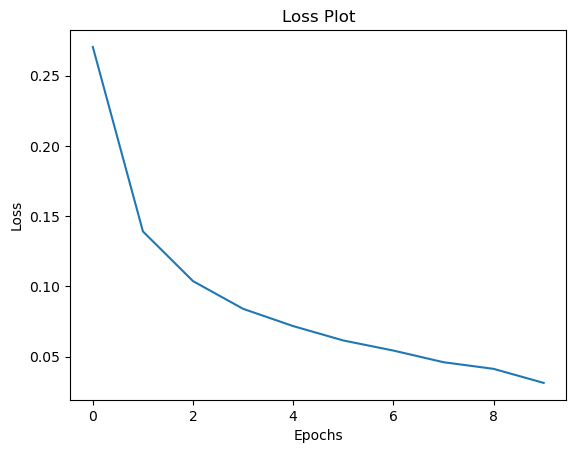

In [4]:
plot_loss(loss)

In [19]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")

Train dataset scores:  accuracy_score: 0.9861833333333333


Test dataset scores:  accuracy_score: 0.9578


In [6]:
from tqdm import tqdm
inner_tqdm = tqdm(test_dataloader, desc=f"Evaluating model", leave=False, position=1)
all_encodings = []
for image, labels in inner_tqdm:
    image = image[0].to(unsupervised_ff.device)
    all_encodings.append(unsupervised_ff.encoding(image).detach().cpu())

all_encodings = torch.stack(all_encodings)


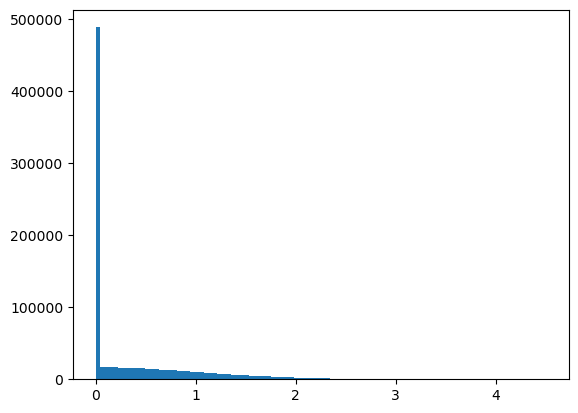

tensor(2392.8008)
torch.Size([1, 1, 6000])
Sparsity:  tensor(0.4390)
Norm ratio:  tensor(43.8967)
shape:  torch.Size([1, 1, 6000])


In [25]:
from matplotlib import pyplot as plt
from torch import norm
plt.hist(all_encodings.flatten().numpy(), bins=100)
plt.show()
print(sum(all_encodings[0][all_encodings[0] > 0]))
print(all_encodings[0].shape)
norm_ratio = torch.norm(all_encodings[0], p=1)/torch.norm(all_encodings[0], p=2)
sparsity = (all_encodings[0].shape[2]**.5-1)/(all_encodings[0].shape[2]**.5-norm_ratio)
print("Sparsity: ", 1/sparsity)
print("Norm ratio: ", norm_ratio)
print("shape: ", all_encodings[0].shape)

In [8]:
def get_weights(model):
    weights = {}
    for idx, layer in enumerate(model.ff_layers):
        weights[f"layer_{idx}"] = layer.weight.data
    weights["last_layer"] = model.last_layer.weight.data
    return weights

In [9]:
print(get_weights(unsupervised_ff))

{'layer_0': tensor([[ 0.0117, -0.0167,  0.0181,  ...,  0.0135,  0.0174, -0.0248],
        [-0.0066,  0.0273,  0.0316,  ..., -0.0287, -0.0226, -0.0013],
        [-0.0344, -0.0227, -0.0243,  ..., -0.0174, -0.0220,  0.0111],
        ...,
        [ 0.0078,  0.0258, -0.0079,  ..., -0.0276, -0.0214,  0.0047],
        [ 0.0345, -0.0238, -0.0135,  ...,  0.0175, -0.0029,  0.0304],
        [ 0.0192, -0.0146, -0.0135,  ..., -0.0325,  0.0048, -0.0078]]), 'layer_1': tensor([[-1.4466e-02,  1.8450e-02,  3.5100e-03,  ...,  2.0445e-02,
         -1.4870e-02, -2.1363e-02],
        [ 1.9133e-02,  1.6387e-02, -1.7799e-04,  ..., -5.4352e-03,
          2.9048e-03,  1.9078e-02],
        [ 1.7017e-02,  1.8745e-02,  7.2045e-03,  ..., -1.5046e-02,
          1.3704e-02, -1.3443e-02],
        ...,
        [-8.7326e-04,  7.9781e-03, -3.4880e-03,  ..., -1.9646e-02,
          8.6006e-03, -7.9806e-03],
        [-2.2157e-02,  1.6733e-02,  2.1975e-02,  ...,  6.6337e-03,
          8.6864e-03, -1.5531e-02],
        [-1.67

In [10]:
def get_sparse_representation(model, image):
    encodings = model.encoding(image)
    return encodings.reshape(-1).detach()

In [11]:
import random
import numpy as np
from scipy.spatial.distance import hamming
sparse_representations = [[] for _ in range(10)]
for x_batch, y_batch in test_dataloader:
    for x, y in zip(x_batch, y_batch):
        sparse_representations[y.item()].append(get_sparse_representation(unsupervised_ff, x))

In [12]:
similarities_c = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            similarity_c = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[i][k].unsqueeze(0))
            similarities_c[i].append(similarity_c.item())

In [13]:
similarities_h = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            binary_i_j = np.where(sparse_representations[i][j].cpu().numpy() > 0, 1, 0)
            binary_random_k = np.where(sparse_representations[i][k].cpu().numpy() > 0, 1, 0)
            similarity_h = hamming(binary_i_j, binary_random_k)
            similarities_h[i].append(similarity_h)

In [14]:
dissimilarities_c = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            while True:
                random_class = random.randint(0,9)
                if random_class != i:
                    break
            dissimilarity_c = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[random_class][k].unsqueeze(0))
            dissimilarities_c[i].append(dissimilarity_c.item())

In [15]:
dissimilarities_h = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            while True:
                random_class = random.randint(0,9)
                if random_class != i:
                    break
            binary_i_j = np.where(sparse_representations[i][j].cpu().numpy() > 0, 1, 0)
            binary_random_k = np.where(sparse_representations[random_class][k].cpu().numpy() > 0, 1, 0)
            dissimilarity_h = hamming(binary_i_j, binary_random_k)
            dissimilarities_h[i].append(dissimilarity_h)

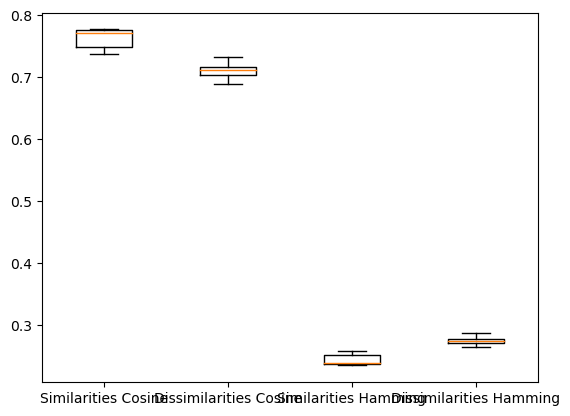

In [16]:
plt.boxplot([np.array(similarities_c).mean(axis=1), np.array(dissimilarities_c).mean(axis=1), np.array(similarities_h).mean(axis=1), np.array(dissimilarities_h).mean(axis=1)], labels=["Similarities Cosine", "Dissimilarities Cosine", "Similarities Hamming", "Dissimilarities Hamming"])
plt.show()

In [17]:
for i in range(10):
    average_similarity_c = np.mean(similarities_c[i])
    print(f"Average cosine similarity for digit {i}: {average_similarity_c}")

    average_similarity_h = np.mean(similarities_h[i])
    print(f"Average hamming similarity for digit {i}: {average_similarity_h}")

    average_dissimilarity_c = np.mean(dissimilarities_c[i])
    print(f"Average cosine dissimilarity for digit {i}: {average_dissimilarity_c}")

    average_dissimilarity_h = np.mean(dissimilarities_h[i])
    print(f"Average hamming dissimilarity for digit {i}: {average_dissimilarity_h}")
    

Average cosine similarity for digit 0: 0.7752882233931094
Average hamming similarity for digit 0: 0.2346859863945578
Average cosine dissimilarity for digit 0: 0.7023465145850668
Average hamming dissimilarity for digit 0: 0.2797302040816326
Average cosine similarity for digit 1: 0.7706106877813533
Average hamming similarity for digit 1: 0.23942149659863945
Average cosine dissimilarity for digit 1: 0.6891316440640664
Average hamming dissimilarity for digit 1: 0.2871317006802721
Average cosine similarity for digit 2: 0.74752599229618
Average hamming similarity for digit 2: 0.2528239455782313
Average cosine dissimilarity for digit 2: 0.712862843834624
Average hamming dissimilarity for digit 2: 0.274071156462585
Average cosine similarity for digit 3: 0.7702583107656362
Average hamming similarity for digit 3: 0.23747904761904762
Average cosine dissimilarity for digit 3: 0.7129772332249855
Average hamming dissimilarity for digit 3: 0.2723344217687075
Average cosine similarity for digit 4: 0.7

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Flatten the sparse_representations into a 2D array and create labels
flattened_representations = []
labels = []
for i in range(10):
    # Move each tensor in the list to CPU before extending flattened_representations
    flattened_representations.extend([tensor.cpu() for tensor in sparse_representations[i]])
    labels.extend([i] * len(sparse_representations[i]))

# Convert list to numpy array after the loop
flattened_representations = np.array(flattened_representations)

# Use TSNE to reduce dimensionality to 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
representations_2d = tsne.fit_transform(flattened_representations)

# Plot the results with different colors for each digit
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(representations_2d[labels == i, 0], representations_2d[labels == i, 1], label=str(i))
plt.legend()
plt.show()
print(flattened_representations)
print(labels)
print(representations_2d)

/var/folders/r_/f9t5sf4n2lj3bmtgm49yq3x00000gp/T/ipykernel_83622/3027386922.py:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  flattened_representations = np.array(flattened_representations)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10000,) + inhomogeneous part.